In [1]:
import torch
import numpy as np

### Pytorch Basic operations

In [2]:
number = torch.tensor(4.)
number

tensor(4.)

In [3]:
number.dtype

torch.float32

In [4]:
t2 = torch.tensor([1., 2, 3, 4])
print(t2)
t2.shape

tensor([1., 2., 3., 4.])


torch.Size([4])

##### Gradient

We can combine tensors with the usual arithmetic operations. Using *requires_grad* in the initializaiton of a pytorch variabl, we signal to trace its gradient. 

In [5]:
# Create tensors.
x = torch.tensor(3.)
w = torch.tensor(4., requires_grad=True)
b = torch.tensor(5., requires_grad=True)
x, w, b

(tensor(3.), tensor(4., requires_grad=True), tensor(5., requires_grad=True))

$$ y = w*x + b, \qquad x = 3, w = 4, b = 5 $$

In [6]:
# Arithmetic operations
y = w * x + b
y

tensor(17., grad_fn=<AddBackward0>)

To compute derivates, we can invoke the *.backward* method

In [7]:
# Compute derivatives
y.backward()

In [8]:
# Display gradients
print('dy/dx:', x.grad)
print('dy/dw:', w.grad)
print('dy/db:', b.grad)

dy/dx: None
dy/dw: tensor(3.)
dy/db: tensor(1.)


#### Creation of tensors

In [9]:
t1 = torch.tensor([[1, 2], [3, 4], [5, 6]])
t2 = torch.full((3, 2), 42)
t2

tensor([[42, 42],
        [42, 42],
        [42, 42]])

In [10]:
t3 = torch.cat((t1, t2))
t3

tensor([[ 1,  2],
        [ 3,  4],
        [ 5,  6],
        [42, 42],
        [42, 42],
        [42, 42]])

In [11]:
torch.sin(t3)

tensor([[ 0.8415,  0.9093],
        [ 0.1411, -0.7568],
        [-0.9589, -0.2794],
        [-0.9165, -0.9165],
        [-0.9165, -0.9165],
        [-0.9165, -0.9165]])

In [12]:
x = np.random.rand(12).reshape(3, 4)

In [13]:
t4 = torch.from_numpy(x)
t4

tensor([[0.0848, 0.9763, 0.5962, 0.3564],
        [0.0794, 0.3084, 0.4527, 0.3402],
        [0.0330, 0.1467, 0.0355, 0.9896]], dtype=torch.float64)

# Linear regression


<img src="https://i.imgur.com/6Ujttb4.png">


In [14]:
# Input (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43], 
                   [91, 88, 64], 
                   [87, 134, 58], 
                   [102, 43, 37], 
                   [69, 96, 70]], dtype='float32')
# Targets (apples, oranges)
targets = np.array([[56, 70], 
                    [81, 101], 
                    [119, 133], 
                    [22, 37], 
                    [103, 119]], dtype='float32')

In [15]:
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

We start with random weights

In [16]:
# Weights and biases
w = torch.randn(2, 3, requires_grad=True)
b = torch.randn(2, requires_grad=True)
print(f"Starting random weights:\n {w}\n")
print(f"Starting random bias:\n {b}")

Starting random weights:
 tensor([[ 0.8702,  0.0286,  0.1502],
        [ 2.4021, -0.9260,  1.0540]], requires_grad=True)

Starting random bias:
 tensor([-0.0211,  0.1151], requires_grad=True)


Our model is simply a function that performs a matrix multiplication of the inputs and the weights w (transposed) and adds the bias b (replicated for each observation).

<img src="https://i.imgur.com/WGXLFvA.png">

In [17]:
def model(x, w, b):
    return x @ w.t() + b

In [18]:
# Generate predictions
preds = model(inputs, w, b)
print(preds)

tensor([[ 71.8808, 158.7490],
        [ 91.3002, 204.6750],
        [ 88.2346, 146.1478],
        [ 95.5283, 244.3089],
        [ 73.2861, 150.7452]], grad_fn=<AddBackward0>)


This results represent the number of Apples (col 1) and Oranges (col 2) for each region (row)

In [19]:
# Compare with targets
print(targets-preds)

tensor([[ -15.8808,  -88.7490],
        [ -10.3002, -103.6750],
        [  30.7654,  -13.1478],
        [ -73.5283, -207.3089],
        [  29.7139,  -31.7452]], grad_fn=<SubBackward0>)


To evaluate how good/bad the model is doing we introduce a *loss* function

In [20]:
# MSE loss - average of squared residuals
def mse(t1, t2):
    diff = t1 - t2
    return torch.sum(diff * diff) / diff.numel()

In [21]:
# Compute loss
loss = mse(preds, targets)
print(loss)

tensor(7037.6626, grad_fn=<DivBackward0>)


In average each prediction differs from the actual value for a number of units equal to the square root of this *loss*. Our goal is to minimize the loss function uswith gradient

In [22]:
# Compute gradients
loss.backward()

In [23]:
# Gradients for weights
print(w)
print(w.grad)

tensor([[ 0.8702,  0.0286,  0.1502],
        [ 2.4021, -0.9260,  1.0540]], requires_grad=True)
tensor([[ 973.9307, -368.5895,   39.6537],
        [8078.5786, 5758.6426, 4221.3149]])


To decrease the loss we must make a small step in the direction opposite of the gradient

In [24]:
lr = 1e-5
with torch.no_grad():
    w -= w.grad * lr
    b -= b.grad * lr

We use torch.no_grad to indicate to PyTorch that we shouldn't track, calculate, or modify gradients while updating the weights and biases.

In [25]:
# Let's verify that the loss is actually lower
loss = mse(model(inputs, w, b), targets)
print(loss)

tensor(5965.0928, grad_fn=<DivBackward0>)


Before we proceed, we reset the gradients to zero by invoking the .zero_() method. We need to do this because PyTorch accumulates gradients. Otherwise, the next time we invoke .backward on the loss, the new gradient values are added to the existing gradients, which may lead to unexpected results.

In [26]:
w.grad.zero_()
b.grad.zero_()
print(w.grad)
print(b.grad)

tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([0., 0.])


In [27]:
# Train for 100 epochs
def train_model(w, b, k):
    loss_list = []
    lr = 1e-5
    for i in range(100):
        preds = model(inputs, w, b)
        loss = mse(preds, targets)
        loss_list.append(loss)
        print(f"epoch[{i}]: loss1 = {loss:.2f}")
        loss.backward()
        with torch.no_grad():
            w -= w.grad * lr
            b -= b.grad * lr
            if( i%k == 0):
                w.grad.zero_()
                b.grad.zero_()
    return loss_list

In [28]:
losses1 = train_model(w, b,10)

epoch[0]: loss1 = 5965.09
epoch[1]: loss1 = 5226.91
epoch[2]: loss1 = 4714.26
epoch[3]: loss1 = 4008.21
epoch[4]: loss1 = 3529.61
epoch[5]: loss1 = 3514.49
epoch[6]: loss1 = 3854.84
epoch[7]: loss1 = 4175.54
epoch[8]: loss1 = 4094.64
epoch[9]: loss1 = 3488.83
epoch[10]: loss1 = 2582.35
epoch[11]: loss1 = 1798.36
epoch[12]: loss1 = 1750.42
epoch[13]: loss1 = 1673.12
epoch[14]: loss1 = 1591.29
epoch[15]: loss1 = 1519.72
epoch[16]: loss1 = 1454.05
epoch[17]: loss1 = 1375.15
epoch[18]: loss1 = 1263.79
epoch[19]: loss1 = 1115.67
epoch[20]: loss1 = 946.40
epoch[21]: loss1 = 782.97
epoch[22]: loss1 = 771.75
epoch[23]: loss1 = 750.58
epoch[24]: loss1 = 721.29
epoch[25]: loss1 = 685.35
epoch[26]: loss1 = 643.32
epoch[27]: loss1 = 595.06
epoch[28]: loss1 = 540.61
epoch[29]: loss1 = 480.92
epoch[30]: loss1 = 418.18
epoch[31]: loss1 = 355.27
epoch[32]: loss1 = 350.80
epoch[33]: loss1 = 342.02
epoch[34]: loss1 = 329.24
epoch[35]: loss1 = 312.82
epoch[36]: loss1 = 293.14
epoch[37]: loss1 = 270.65
ep

In [29]:
w2 = torch.randn(2, 3, requires_grad=True)
b2 = torch.randn(2, requires_grad=True)
losses2 = train_model(w2, b2, 1)

epoch[0]: loss1 = 13817.23
epoch[1]: loss1 = 9517.01
epoch[2]: loss1 = 6616.68
epoch[3]: loss1 = 4659.74
epoch[4]: loss1 = 3338.58
epoch[5]: loss1 = 2445.88
epoch[6]: loss1 = 1841.95
epoch[7]: loss1 = 1432.65
epoch[8]: loss1 = 1154.53
epoch[9]: loss1 = 964.85
epoch[10]: loss1 = 834.78
epoch[11]: loss1 = 744.93
epoch[12]: loss1 = 682.19
epoch[13]: loss1 = 637.76
epoch[14]: loss1 = 605.69
epoch[15]: loss1 = 581.98
epoch[16]: loss1 = 563.93
epoch[17]: loss1 = 549.72
epoch[18]: loss1 = 538.11
epoch[19]: loss1 = 528.30
epoch[20]: loss1 = 519.71
epoch[21]: loss1 = 511.98
epoch[22]: loss1 = 504.84
epoch[23]: loss1 = 498.14
epoch[24]: loss1 = 491.74
epoch[25]: loss1 = 485.58
epoch[26]: loss1 = 479.60
epoch[27]: loss1 = 473.76
epoch[28]: loss1 = 468.04
epoch[29]: loss1 = 462.43
epoch[30]: loss1 = 456.91
epoch[31]: loss1 = 451.47
epoch[32]: loss1 = 446.11
epoch[33]: loss1 = 440.82
epoch[34]: loss1 = 435.60
epoch[35]: loss1 = 430.46
epoch[36]: loss1 = 425.37
epoch[37]: loss1 = 420.36
epoch[38]: l

In [30]:
import matplotlib.pyplot as plt

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

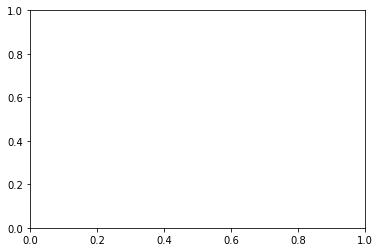

In [31]:
plt.plot(range(100), losses1, label="1")
plt.plot(range(100), losses2, label="2")
plt.legend()
plt.show()

### Linear regression using PyTorch built-ins
We've implemented linear regression & gradient descent model using some basic tensor operations. However, since this is a common pattern in deep learning, PyTorch provides several built-in functions and classes to make it easy to create and train models with just a few lines of code.

###### Data loading

In [32]:


# Input (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43], 
                   [91, 88, 64], 
                   [87, 134, 58], 
                   [102, 43, 37], 
                   [69, 96, 70], 
                   [74, 66, 43], 
                   [91, 87, 65], 
                   [88, 134, 59], 
                   [101, 44, 37], 
                   [68, 96, 71], 
                   [73, 66, 44], 
                   [92, 87, 64], 
                   [87, 135, 57], 
                   [103, 43, 36], 
                   [68, 97, 70]], 
                  dtype='float32')

# Targets (apples, oranges)
targets = np.array([[56, 70], 
                    [81, 101], 
                    [119, 133], 
                    [22, 37], 
                    [103, 119],
                    [57, 69], 
                    [80, 102], 
                    [118, 132], 
                    [21, 38], 
                    [104, 118], 
                    [57, 69], 
                    [82, 100], 
                    [118, 134], 
                    [20, 38], 
                    [102, 120]], 
                   dtype='float32')

inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)
inputs

tensor([[ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.],
        [ 74.,  66.,  43.],
        [ 91.,  87.,  65.],
        [ 88., 134.,  59.],
        [101.,  44.,  37.],
        [ 68.,  96.,  71.],
        [ 73.,  66.,  44.],
        [ 92.,  87.,  64.],
        [ 87., 135.,  57.],
        [103.,  43.,  36.],
        [ 68.,  97.,  70.]])

In [33]:
from torch.utils.data import TensorDataset

In [34]:
# Define dataset
train_ds = TensorDataset(inputs, targets)
train_ds[0:3]

(tensor([[ 73.,  67.,  43.],
         [ 91.,  88.,  64.],
         [ 87., 134.,  58.]]),
 tensor([[ 56.,  70.],
         [ 81., 101.],
         [119., 133.]]))

The TensorDataset allows us to access a small section of the training data using the array indexing notation ([0:3] in the above code). It returns a tuple with two elements. The first element contains the input variables for the selected rows, and the second contains the targets.

We'll also create a DataLoader, which can split the data into batches of a predefined size while training. It also provides other utilities like shuffling and random sampling of the data.

In [35]:
from torch.utils.data import DataLoader
# Define data loader
batch_size = 5
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [36]:
for xb, yb in train_dl:
    print(xb)
    print(yb)
    break

tensor([[ 92.,  87.,  64.],
        [ 73.,  67.,  43.],
        [101.,  44.,  37.],
        [ 87., 135.,  57.],
        [ 68.,  96.,  71.]])
tensor([[ 82., 100.],
        [ 56.,  70.],
        [ 21.,  38.],
        [118., 134.],
        [104., 118.]])


###### Model loading
Instead of initializing the weights & biases manually, we can define the model using the nn.Linear class from PyTorch, which does it automatically.

In [37]:
import torch.nn as nn

# Define model
model = nn.Linear(3, 2)
print(model.weight)
print(model.bias)

Parameter containing:
tensor([[ 0.3554, -0.4510,  0.2152],
        [-0.2543, -0.0348, -0.1468]], requires_grad=True)
Parameter containing:
tensor([0.2510, 0.4019], requires_grad=True)


PyTorch models also have a helpful .parameters method, which returns a list containing all the weights and bias matrices present in the model. For our linear regression model, we have one weight matrix and one bias matrix.

In [38]:
# Parameters
list(model.parameters())

[Parameter containing:
 tensor([[ 0.3554, -0.4510,  0.2152],
         [-0.2543, -0.0348, -0.1468]], requires_grad=True),
 Parameter containing:
 tensor([0.2510, 0.4019], requires_grad=True)]

In [39]:
# Generate predictions
preds = model(inputs)
preds

tensor([[  5.2305, -26.8086],
        [  6.6751, -35.2007],
        [-16.7829, -34.9047],
        [ 25.0698, -32.4661],
        [ -3.4606, -30.7659],
        [  6.0368, -27.0281],
        [  7.3413, -35.3127],
        [-16.2123, -35.3059],
        [ 24.2634, -32.2466],
        [ -3.6008, -30.6585],
        [  5.8966, -26.9206],
        [  7.4815, -35.4201],
        [-17.4490, -34.7927],
        [ 25.2100, -32.5736],
        [ -4.2670, -30.5465]], grad_fn=<AddmmBackward>)

###### Loss function

In [40]:
# Import nn.functional
import torch.nn.functional as F

# Define loss function
loss_fn = F.mse_loss

loss = loss_fn(model(inputs), targets)
print(loss)

tensor(12111.2471, grad_fn=<MseLossBackward>)


###### Optimizer

In [41]:
# Define optimizer
opt = torch.optim.SGD(model.parameters(), lr=1e-5)

Note that model.parameters() is passed as an argument to optim.SGD so that the optimizer knows which matrices should be modified during the update step. In complex models different branches of the structure can use different optimizers, so not all the parameters of the network must be passed.
Also, we can specify a learning rate that controls the amount by which the parameters are modified.

###### Training loop

In [42]:
# Utility function to train the model
def fit(num_epochs, model, loss_fn, opt, train_dl):
    
    # Repeat for given number of epochs
    for epoch in range(num_epochs):
        
        # Train with batches of data
        for xb,yb in train_dl:
            
            # 1. Generate predictions
            pred = model(xb)
            
            # 2. Calculate loss
            loss = loss_fn(pred, yb)
            
            # 3. Compute gradients
            loss.backward()
            
            # 4. Update parameters using gradients
            opt.step()
            
            # 5. Reset the gradients to zero
            opt.zero_grad()
        
        # Print the progress
        if (epoch+1) % 10 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

In [43]:
fit(100, model, loss_fn, opt, train_dl)


Epoch [10/100], Loss: 939.6053
Epoch [20/100], Loss: 644.2755
Epoch [30/100], Loss: 69.4752
Epoch [40/100], Loss: 215.5510
Epoch [50/100], Loss: 58.9203
Epoch [60/100], Loss: 153.0536
Epoch [70/100], Loss: 96.8771
Epoch [80/100], Loss: 11.6436
Epoch [90/100], Loss: 33.1873
Epoch [100/100], Loss: 30.0437
